In [2]:
import os
import tarfile
import shutil
from sklearn.model_selection import train_test_split
import requests
import zipfile

# Step 1: Download and Extract the Dataset
def download_and_extract(dataset_url, extract_to):
    zip_path = 'caltech101.zip'
    # Download the dataset
    print("Downloading dataset...")
    response = requests.get(dataset_url, stream=True)
    with open(zip_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)
    print("Download complete.")

    # Extract the dataset
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Zip extraction complete.")

    # Check for tar file inside extracted folder
    tar_path = os.path.join(extract_to, "caltech-101", "101_ObjectCategories.tar.gz")
    if os.path.exists(tar_path):
        print("Extracting .tar file...")
        with tarfile.open(tar_path, 'r') as tar_ref:
            tar_ref.extractall(extract_to)
        print(".tar extraction complete.")

def split_data(source_dir, train_dir, val_dir, test_dir, val_size=0.2, test_size=0.1):
    """
    Splits the dataset into train, validation, and test sets.

    Args:
    - source_dir: Directory containing the dataset with categories as subdirectories.
    - train_dir: Directory to save training data.
    - val_dir: Directory to save validation data.
    - test_dir: Directory to save test data.
    - val_size: Proportion of the dataset to use for validation (relative to train + val).
    - test_size: Proportion of the dataset to use for testing (relative to the total data).
    """
    print("Splitting dataset into train, validation, and test sets...")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    for category in os.listdir(source_dir):
        category_path = os.path.join(source_dir, category)
        if os.path.isdir(category_path):
            images = os.listdir(category_path)

            # Split into train+val and test
            train_val_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

            # Further split train+val into train and val
            train_images, val_images = train_test_split(train_val_images, test_size=val_size / (1 - test_size), random_state=42)

            # Create category subdirectories
            os.makedirs(os.path.join(train_dir, category), exist_ok=True)
            os.makedirs(os.path.join(val_dir, category), exist_ok=True)
            os.makedirs(os.path.join(test_dir, category), exist_ok=True)

            # Copy images to respective directories
            for img in train_images:
                shutil.copy(os.path.join(category_path, img), os.path.join(train_dir, category, img))
            for img in val_images:
                shutil.copy(os.path.join(category_path, img), os.path.join(val_dir, category, img))
            for img in test_images:
                shutil.copy(os.path.join(category_path, img), os.path.join(test_dir, category, img))

    print("Dataset split completed.")


# Step 3: Run the Complete Workflow
dataset_url = "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip"
base_dir = "/content"
extract_to = os.path.join(base_dir)
source_dir = os.path.join(base_dir, "101_ObjectCategories")
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir=os.path.join(base_dir, "test")

# Download, Extract, and Split
download_and_extract(dataset_url, base_dir)
!rm -rf  '101_ObjectCategories/BACKGROUND_Google' #Linux

if os.path.exists(source_dir):
    split_data(source_dir, train_dir, val_dir,test_dir)
else:
    print(f"Source directory not found: {source_dir}")

print("Train directory:", train_dir)
print("Validation directory:", val_dir)

Download complete.
Extracting dataset...
Zip extraction complete.
Extracting .tar file...
.tar extraction complete.
Splitting dataset into train, validation, and test sets...
Dataset split completed.
Train directory: /content/train
Validation directory: /content/val


In [9]:
from keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os

def load_and_preprocess_custom_data(data_dir, target_size=(128, 128)):
    """
    Load and preprocess images from a directory structure.
    Args:
    - data_dir: Directory containing labeled subfolders.
    - target_size: Tuple specifying the target size for resizing images.

    Returns:
    - images: Preprocessed image data as a NumPy array.
    - labels: Corresponding labels for the images.
    """
    images = []
    labels = []
    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                # Load, resize, and normalize image
                img = load_img(img_path, target_size=target_size, color_mode="grayscale")
                img_array = img_to_array(img) / 255.0
                images.append(img_array)
                labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Load data
train_images, train_labels = load_and_preprocess_custom_data(train_dir)
val_images, val_labels = load_and_preprocess_custom_data(val_dir)
test_images, test_labels = load_and_preprocess_custom_data(test_dir)


In [10]:
x_train = train_images
x_test = val_images


Epoch 1/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - loss: 0.6290 - val_loss: 0.5161
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - loss: 0.5176 - val_loss: 0.5044
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - loss: 0.5092 - val_loss: 0.5002
Epoch 4/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - loss: 0.5014 - val_loss: 0.4992
Epoch 5/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - loss: 0.5012 - val_loss: 0.4951
Epoch 6/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - loss: 0.4995 - val_loss: 0.4934
Epoch 7/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 254s 3s/step - loss: 0.4969 - val_loss: 0.4924
Epoch 8/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - loss: 0.4962 - val_loss: 0.4921
Epoch 9/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - loss: 0.4958 - val_loss: 0.4901
Epoch 10/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - loss: 0.4925 - val_loss: 0.4899
Epoch 11/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - loss: 0.4934 - val_loss: 0.4889
Epoch 12/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - loss: 0.4

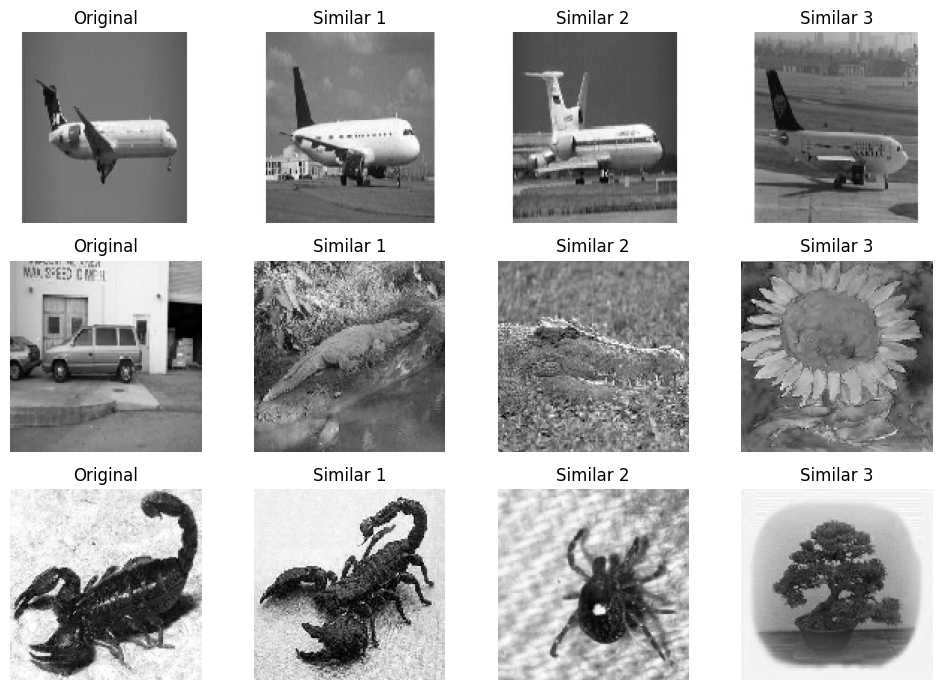

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist
from keras.optimizers import Adam
from scipy.spatial.distance import cdist

# def load_and_preprocess_data():
#     """Load and preprocess the MNIST dataset."""
#     (x_train, _), (x_test, _) = mnist.load_data()
#     x_train = np.expand_dims(x_train, axis=-1).astype('float32') / 255.
#     x_test = np.expand_dims(x_test, axis=-1).astype('float32') / 255.
#     return x_train, x_test

def build_autoencoder():
    """Build and compile the CNN-based autoencoder."""
    # Input layer: accepts images of shape 28x28x1 (MNIST images)
    input_img = Input(shape=(128, 128, 1))

    # Encoder
    # Convolutional layer with 32 filters, each 3x3, using 'relu' activation. 'same' padding ensures output size matches input size.
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    # Max pooling layer to reduce spatial dimensions by half, improving computational efficiency and helping encode positional information.
    x = MaxPooling2D((2, 2), padding='same')(x)
    # Another convolutional layer with 16 filters to further extract features from the image.
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    # Reducing spatial dimensions again to further compress the representation.
    x = MaxPooling2D((2, 2), padding='same')(x)
    # Final convolutional layer in the encoder with 8 filters, focusing on the most abstract features of the image.
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    # Last max pooling layer in the encoder to achieve the final compressed representation.
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    # Convolutional layer with 8 filters, starting the process of decoding the compressed representation.
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    # Upsampling layer to start expanding the spatial dimensions back to the original size.
    x = UpSampling2D((2, 2))(x)
    # Convolutional layer with 16 filters to further refine the decoded features.
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    # Upsampling again to get closer to the original image size.
    x = UpSampling2D((2, 2))(x)
    # Convolutional layer with 32 filters, nearly restoring the original depth of features.
    # x = Conv2D(32, (3, 3), activation='relu')(x)  # Note: No padding here, changes size slightly.
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Fixed here

    # Final upsampling to match the original image dimensions.
    x = UpSampling2D((2, 2))(x)
    # Output layer to reconstruct the original image. Uses 'sigmoid' activation to output pixel values between 0 and 1.
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Compiling the autoencoder model with Adam optimizer and binary cross-entropy loss.
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    return autoencoder


def train_autoencoder(autoencoder, x_train, x_test):
    """Train the autoencoder."""
    autoencoder.fit(x_train, x_train, epochs=15, batch_size=64, shuffle=True, validation_data=(x_test, x_test))

def generate_embeddings(encoder, x_test):
    """Generate embeddings for the test set."""
    return encoder.predict(x_test)

def find_similar_images(embeddings, selected_indices):
    """Find and return indices of similar images based on embeddings."""
    similar_images_indices = []
    for index in selected_indices:
        distances = cdist(embeddings[index:index+1], embeddings, 'euclidean')
        closest_indices = np.argsort(distances)[0][1:4]  # Exclude self
        similar_images_indices.append(closest_indices)
    return similar_images_indices

def display_similar_images(x_test, selected_indices, similar_images_indices):
    """Visualize the original and similar images."""
    plt.figure(figsize=(10, 7))
    for i, (index, sim_indices) in enumerate(zip(selected_indices, similar_images_indices)):
        ax = plt.subplot(3, 4, i * 4 + 1)
        plt.imshow(x_test[index].reshape(128, 128))
        plt.title("Original")
        plt.gray()
        ax.axis('off')

        for j, sim_index in enumerate(sim_indices):
            ax = plt.subplot(3, 4, i * 4 + j + 2)
            plt.imshow(x_test[sim_index].reshape(128, 128))
            plt.title(f"Similar {j+1}")
            plt.gray()
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Main workflow
# x_train, x_test = load_and_preprocess_data()
autoencoder = build_autoencoder()
train_autoencoder(autoencoder, x_train, x_test)

encoder = Model(autoencoder.input, autoencoder.layers[-7].output)
encoded_imgs = generate_embeddings(encoder, np.reshape(x_test, (len(x_test), 128, 128, 1)))
encoded_imgs_flatten = encoded_imgs.reshape((len(x_test), np.prod(encoded_imgs.shape[1:])))

np.random.seed(0)
selected_indices = np.random.choice(x_test.shape[0], 3, replace=False)
similar_images_indices = find_similar_images(encoded_imgs_flatten, selected_indices)
display_similar_images(x_test, selected_indices, similar_images_indices)


In [15]:
# Save the trained autoencoder model
autoencoder.save('autoencoder_model.h5')